In [5]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import re

In [3]:
BIAS_DATA = "../data/bias_scores.csv"
bias_df = pd.read_csv(BIAS_DATA)
bias_df.head()


,domain,score,fb_score,mturk_score,budak_score,allsides_score,allsides_score_community,pew_score
0,bitly.com,0.0543,NaN,NaN,NaN,NaN,NaN,NaN
1,youtube.com,0.1282,0.0634,0.000000,NaN,NaN,NaN,NaN
2,instagram.com,0.1427,NaN,0.000000,NaN,NaN,NaN,NaN
3,facebook.com,0.1132,NaN,-0.083333,NaN,NaN,NaN,NaN
4,ow.ly,0.0882,NaN,0.000000,NaN,NaN,NaN,NaN


In [6]:
url = 'www.py4u.net'
# url = 'https://www.google.com'
print(url)

www_re = re.compile(r"(www\.)?")
url = www_re.sub('', url)
print(url)

www.py4u.net
py4u.net


In [7]:
import re



def get_bias_score(urls):
    '''
    pass in a list urls return the mean media bias score
    or nan if none if the urls is included in the media bias
    database
    '''
    scores = []

    # get path of the url
    urls = [urlparse(u).path for u in urls]
    # remove www if there is
    www_re = re.compile(r"(www\.)?")
    urls = [www_re.sub('', u) for u in urls]
    for u in urls:
        # takes the mean of the matched results
        ss = bias_df[bias_df['domain'].str.match(u)]['score']
        if not ss.empty:
            scores.append(ss.mean())

    if scores:
        return np.nanmean(scores)
    else:
        return np.nan



print(get_bias_score(["www.not_exist.com", "www.xx.com"]))
print(get_bias_score(["google.com", "www.politicio.com"]))

nan
0.16504285714285713


In [8]:
# QUOTE_FILE = '../data/quotes_mentions_USA_compact.json.bz2'
# QUOTE_FILE = '../data/quotes_mentions_USA_ML.json.bz2'
QUOTE_FILE = '../data/quotes_mentions_world_compact.json.bz2'
df = pd.read_json(QUOTE_FILE, lines=True, compression='bz2')
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,country
0,2015-07-24-075914,Prime Minister Modi recognizes the vital role ...,Michael R. Bloomberg,Q607,2015-07-24 15:56:32,1,E,[Narendra Modi],[Q1058],[businessfacilities.com],[India]
1,2015-09-24-093742,The growing reach of China's army of cyberwarr...,President Barack Obama,Q76,2015-09-24 13:50:51,2,E,[Xi Jinping],[Q15031],"[www.defenseone.com, defenseone.com]",[People's Republic of China]
2,2015-12-21-013885,deal with [ Putin ],Marco Rubio,Q324546,2015-12-21 00:00:00,1,E,[Vladimir Putin],[Q7747],[latinpost.com],[Russia]
3,2015-01-09-015364,free for eve... Girls basketball notebook: Rul...,President Barack Obama,Q76,2015-01-09 03:37:35,1,E,[Maithripala Sirisena],[Q6737124],[billingsgazette.com],[Sri Lanka]
4,2015-02-11-030684,I hope the president does see the value of let...,Madeleine Albright,Q174438,2015-02-11 18:35:22,1,E,"[Angela Merkel, Vladimir Putin]","[Q567, Q7747]",[breitbart.com],"[Germany, Russia]"


In [9]:
df.urls

0                                 [businessfacilities.com]
1                     [www.defenseone.com, defenseone.com]
2                                          [latinpost.com]
3                                    [billingsgazette.com]
4                                          [breitbart.com]
                               ...                        
26170                                     [www.cityam.com]
26171          [freepressjournal.in, www.thestatesman.com]
26172                                [floridapolitics.com]
26173    [www.duluthnewstribune.com, feeds.foxnews.com,...
26174                                    [www.nytimes.com]
Name: urls, Length: 26175, dtype: object

<AxesSubplot:ylabel='Count'>

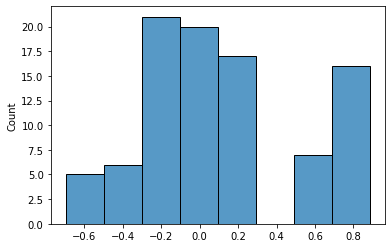

In [10]:
import seaborn as sns

# see the distribution of first 100 quotations
scores = [get_bias_score(urls) for urls in df['urls'].iloc[:100]]
sns.histplot(scores)

In [11]:
import os, time, bz2

READ_FILE = '../data/quotes_mentions_world_compact.json.bz2'
SAVE_FILE = '../data/quotes_mentions_world_bias.json.bz2'

CHUNKSIZE = 3000

try:
    os.remove(SAVE_FILE)
except:
    pass

total_time,total_mentions,chunk_number,nb_quote=0,0,0,0
mentions=[]


with bz2.open(SAVE_FILE, 'wb') as bz_writer:
    with pd.read_json(READ_FILE, lines=True, chunksize=CHUNKSIZE, compression='bz2' ) as df_reader:
        for chunk in df_reader:
            t1=time.time()

            # get bias
            bias = [get_bias_score(urls) for urls in chunk['urls']]
            chunk["source_bias"] = bias

            chunk.to_json(path_or_buf=bz_writer,orient='records',lines=True)
            mentions = len(chunk)
            total_mentions += mentions
            t2=time.time()
            dt=t2-t1
            total_time+=dt
            chunk_number += 1
            print("Dumped {} quotations out of {} quotations [quotations/s: {:.2f}]".format(mentions, CHUNKSIZE, CHUNKSIZE / dt))

Dumped 3000 quotations out of 3000 quotations [quotations/s: 42.38]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 27.46]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 24.89]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 25.23]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 26.87]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 27.56]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 32.98]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 42.15]
Dumped 2175 quotations out of 3000 quotations [quotations/s: 57.47]


source not found ratio 13.32%


<AxesSubplot:xlabel='source_bias', ylabel='Count'>

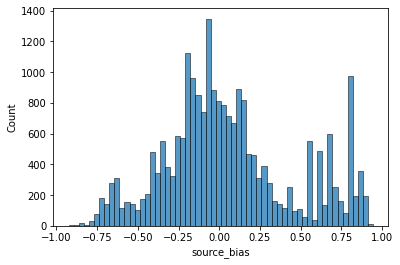

In [16]:
world_file = '../data/quotes_mentions_world_bias.json.bz2'


df = pd.read_json(SAVE_FILE, lines=True, compression='bz2' )
print('source not found ratio {:.2%}'.format(len(df[df['source_bias'].isna()]) / len(df)) )
sns.histplot(df['source_bias'])